In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet201, VGG16, VGG19, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import HeUniform

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve

import sklearn
from sklearn.model_selection import train_test_split
import os
import numpy as np
import os
import shutil
import random
from matplotlib import pyplot as plt
import matplotlib

print("\nLibraries\n-----------------------------")
print(f"Tensorflow: {tf.__version__}")
print(f"Scikit Learn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")


Libraries
-----------------------------
Tensorflow: 2.12.0
Scikit Learn: 1.2.1
Numpy: 1.22.1
Matplotlib: 3.7.0


In [2]:
def count_files_in_directory(directory_path):
    total_files = 0

    for root, _, files in os.walk(directory_path):
        total_files += len(files)

    return total_files

In [3]:
def create_test_set(source_dir, test_dir, class_names, test_percent):
    os.makedirs(test_dir, exist_ok = True)
    
    for class_name in class_names:
        class_source_dir = os.path.join(source_dir, class_name)
        class_test_dir = os.path.join(test_dir, class_name)
        os.makedirs(class_test_dir, exist_ok = True)
        
        images = os.listdir(class_source_dir)
        num_images = len(images)
        num_test_images = int(test_percent * num_images)
        
        test_indices = random.sample(range(num_images), num_test_images)
        
        for index in test_indices:
            image_name = images[index]
            source_path = os.path.join(class_source_dir, image_name)
            target_path = os.path.join(class_test_dir, image_name)
            shutil.move(source_path, target_path)

In [4]:
# Define image dimensions and other parameters
img_height, img_width = 80, 400
num_classes = 3

data_dir = "./DS2/Train"
class_names = os.listdir(data_dir)

# test set
source_data_dir = "./DS2/Train"
test_data_dir = "./DS2/Testset"
valid_data_dir = "./DS2/Validset"
class_names = os.listdir(source_data_dir)

first_execution = True

if first_execution:
    create_test_set(source_data_dir, test_data_dir, class_names, 0.3)
    create_test_set(source_data_dir, valid_data_dir, class_names, 0.2)

In [5]:
datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1.0 / 255.00
)

data_generator = datagen.flow_from_directory(
    data_dir,
    target_size = (img_height, img_width),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True,
    classes = class_names
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        "./DS2/Validset",
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'categorical',
        shuffle = True,
        classes = class_names
)

Found 370 images belonging to 3 classes.
Found 130 images belonging to 3 classes.


In [6]:
input_layer = Input(shape = (img_height, img_width, 3))

# first block

conv1 = Conv2D(
    filters = 32, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(input_layer)
conv1 = Activation('relu')(conv1)
norm1 = BatchNormalization()(conv1)

conv2 = Conv2D(
    filters = 32, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm1)
conv2 = Activation('relu')(conv2)
norm2 = BatchNormalization()(conv2)

pool1 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1), 
    padding = 'same'
)(norm2)

dropout1 = Dropout(0.2)(pool1)

# second block

conv3 = Conv2D(
    filters = 64, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(dropout1)
conv3 = Activation('relu')(conv3)
norm3 = BatchNormalization()(conv3)

conv4 = Conv2D(
    filters = 64, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm3)
conv4 = Activation('relu')(conv4)
norm4 = BatchNormalization()(conv4)

pool2 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1),
    padding = 'same'
)(norm4)

dropout2 = Dropout(0.3)(pool2)

# third block

conv5 = Conv2D(
    filters = 128, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(dropout2)
conv5 = Activation('relu')(conv5)
norm5 = BatchNormalization()(conv5)

conv6 = Conv2D(
    filters = 128, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm5)
conv6 = Activation('relu')(conv6)
norm6 = BatchNormalization()(conv6)

pool3 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1), 
    padding = 'same'
)(norm6)

dropout3 = Dropout(0.4)(pool3)

# fourth block

conv7 = Conv2D(
    filters = 512, 
    kernel_size = (3, 3), 
    strides = (2, 2),  
    padding = 'same',
    kernel_initializer = HeUniform()
)(dropout3)
conv7 = Activation('relu')(conv7)
norm7 = BatchNormalization()(conv7)

conv8 = Conv2D(
    filters = 512, 
    kernel_size = (3, 3), 
    strides = (2, 2), 
    padding = 'same',
    kernel_initializer = HeUniform()
)(norm7)
conv8 = Activation('relu')(conv8)
norm8 = BatchNormalization()(conv8)

pool4 = MaxPooling2D(
    pool_size = (2, 2), 
    strides = (1, 1), 
    padding = 'same'
)(norm8)

dropout4 = Dropout(0.4)(pool4)

flatten = Flatten()(dropout4)

dense1 = Dense(128, activation = 'relu')(flatten)
norm9 = BatchNormalization()(dense1)
dropout5 = Dropout(0.5)(norm9)
output_layer = Dense(num_classes,
                      activation = 'softmax')(dropout5)

model = Model(inputs = input_layer, outputs = output_layer)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 400, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 40, 200, 32)       896       
                                                                 
 activation (Activation)     (None, 40, 200, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 40, 200, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 100, 32)       9248      
                                                                 
 activation_1 (Activation)   (None, 20, 100, 32)       0         
                                                             

In [8]:
model.compile(optimizer = SGD(learning_rate = 0.001, momentum = 0.9),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(data_generator, epochs = 100,
                    validation_data = validation_generator, verbose = 0)

### Please note that the following curves a clear example of overfitting, this is seen by a clear divergence in training (blue) and validation loss (organge curve). Curves should ideally show convergence while a small gap should exist between the two curves to wards the end of the training cycle

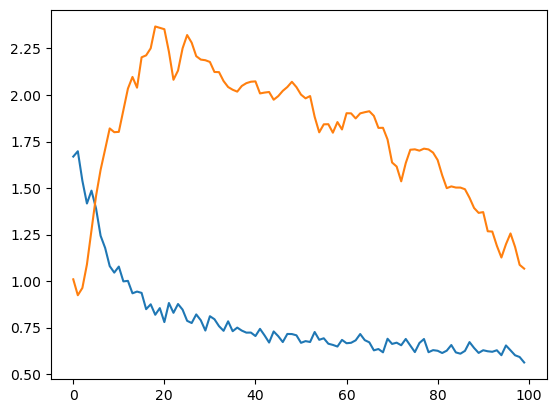

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

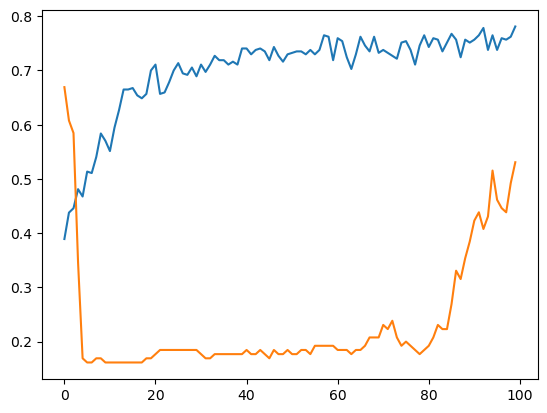

In [10]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [11]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    class_mode = 'categorical',
    batch_size = count_files_in_directory(test_data_dir),
    shuffle = False,
    classes = class_names
)

Found 194 images belonging to 3 classes.


In [12]:
real_labels = []
test_probs = []
test_labels = []
test_errors = []
batch_images, batch_labels = next(test_generator)

for individual_image in range(batch_images.shape[0]):
    single_image_array = batch_images[individual_image]
    single_image_label = batch_labels[individual_image]
    
    test_prob = model.predict(np.expand_dims(single_image_array, axis=0), verbose = 0)
    test_pred = np.argmax(test_prob)
    test_error = np.sqrt(np.mean((test_prob - single_image_label) ** 2))
    
    
    real_labels.append(single_image_label)
    test_probs.append(test_prob[0, test_pred])
    test_labels.append(test_pred)
    test_errors.append(test_error)

test_probs = np.array(test_probs).reshape(-1)
test_labels = np.array(test_labels).reshape(-1)
test_errors = np.array(test_errors).reshape(-1)

In [13]:
class_labels = []
for array in real_labels:
    class_label = np.argmax(array)
    class_labels.append(class_label)
real_labels = class_labels
indices0 = [index for index, value in enumerate(real_labels) if value == 0]
indices1 = [index for index, value in enumerate(real_labels) if value == 1]
indices2 = [index for index, value in enumerate(real_labels) if value == 2]

### Please note through both loss values and the confusion matrix that the algorithm is unable to identify trampling marks succesfully with the highest loss values as well. This is due to the large imbalance between the classes in the dataset

In [14]:
print(f"Test Tooth Score Loss {np.mean(test_errors[indices1]) * 100:.2f}%")
print(f"Test Cut Mark Loss {np.mean(test_errors[indices0]) * 100:.2f}%")
print(f"Test Trampling Mark Loss {np.mean(test_errors[indices2]) * 100:.2f}%")
print(f"Overall Loss {np.mean(test_errors) * 100:.2f}%")

Test Tooth Score Loss 38.01%
Test Cut Mark Loss 8.33%
Test Trampling Mark Loss 57.53%
Overall Loss 17.49%


In [15]:
print(classification_report(real_labels, test_labels))
print(confusion_matrix(real_labels, test_labels))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       146
           1       0.73      0.63      0.68        30
           2       0.00      0.00      0.00        18

    accuracy                           0.84       194
   macro avg       0.53      0.54      0.53       194
weighted avg       0.76      0.84      0.80       194

[[144   2   0]
 [ 11  19   0]
 [ 13   5   0]]


C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\l.courtenay\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [16]:
return_files = True

if return_files:
    source_folders = ["./DS2/Testset", "./DS2/Validset"]
    destination_folder = "./DS2/Train"

    for source_folder in source_folders:
        source_path = os.path.join(source_folder, "CutMark")
        destination_path = os.path.join(destination_folder, "CutMark")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Score")
        destination_path = os.path.join(destination_folder, "Score")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

        source_path = os.path.join(source_folder, "Trampling")
        destination_path = os.path.join(destination_folder, "Trampling")

        # Move files from source subfolder to destination subfolder
        for filename in os.listdir(source_path):
            source_file = os.path.join(source_path, filename)
            destination_file = os.path.join(destination_path, filename)
            shutil.move(source_file, destination_file)

    print("Files moved successfully.")

Files moved successfully.


In [17]:
import winsound
winsound.Beep(1000, 2000)  # Beep at 1000 Hz for 200 milliseconds